# Transformer모델을 이용한 번역기 만들기

## 1. 데이터 확인

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
 
%config InlineBackend.figure_format = 'retina'
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import re
import os
import io
import time
import random

import seaborn # Attention 시각화를 위해 필요!
from sklearn.model_selection import train_test_split

In [3]:
korean_path = os.getenv('HOME') + '/aiffel/transformer/korean-english-park.train/korean-english-park.train.ko'
english_path = os.getenv('HOME') + '/aiffel/transformer/korean-english-park.train/korean-english-park.train.en'

with open(korean_path, 'r') as f:
    korean = f.read().splitlines()
    
print(korean[4])

with open(english_path, 'r') as f:
    english = f.read().splitlines()

print(english[4])

정보 관리들은 동남 아시아에서의 선박들에 대한 많은 (테러) 계획들이 실패로 돌아갔음을 밝혔으며, 세계 해상 교역량의 거의 3분의 1을 운송하는 좁은 해로인 말라카 해협이 테러 공격을 당하기 쉽다고 경고하고 있다.
Intelligence officials have revealed a spate of foiled plots on ships in Southeast Asia and are warning that a narrow stretch of water carrying almost one third of the world's maritime trade is vulnerable to a terror attack.


## 2. 데이터 전처리

In [4]:
cleaned_corpus = list(set(zip(korean, english)))

In [5]:
def preprocess_sentence(sentence):

    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub("[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z?.!,1-9\\s]", "", sentence)

    sentence = sentence.strip()

    
    return sentence

In [6]:
def preprocessing(cleaned_corpus):
    kor_corpus = []
    eng_corpus = []
    for sentence in cleaned_corpus:
        sentence_ko = preprocess_sentence(sentence[0])
        sentence_en = preprocess_sentence(sentence[1])
        kor_corpus.append(sentence_ko)
        eng_corpus.append(sentence_en)
    
    return kor_corpus, eng_corpus

In [7]:
kor_corpus, eng_corpus = preprocessing(cleaned_corpus)

## 3. Sentencepiece를 이용한 Tokenizing

In [8]:
def generate_tokenizer1(corpus,
                       vocab_size,
                       lang="ko",
                       pad_id=0,
                       bos_id=1,
                       eos_id=2,
                       unk_id=3):
    file = "./%s_corpus.txt" % lang
    model = "%s_spm" % lang

    with open(file, 'w') as f:
        for row in corpus: f.write('{}\n'.format(row))

    import sentencepiece as spm
    spm.SentencePieceTrainer.Train(
        '--input=./%s --model_prefix=%s --vocab_size=%d'\
        % (file, model, vocab_size) + \
        '--pad_id==%d --bos_id=%d --eos_id=%d --unk_id=%d'\
        % (pad_id, bos_id, eos_id, unk_id)
    )

    tokenizer = spm.SentencePieceProcessor()
    tokenizer.Load('%s.model' % model)

    return tokenizer

In [9]:
def generate_tokenizer2(corpus,
                       vocab_size,
                       lang="eng",
                       pad_id=0,
                       bos_id=1,
                       eos_id=2,
                       unk_id=3):
    file = "./%s_corpus.txt" % lang
    model = "%s_spm" % lang

    with open(file, 'w') as f:
        for row in corpus: f.write('{}\n'.format(row))

    import sentencepiece as spm
    spm.SentencePieceTrainer.Train(
        '--input=./%s --model_prefix=%s --vocab_size=%d'\
        % (file, model, vocab_size) + \
        '--pad_id==%d --bos_id=%d --eos_id=%d --unk_id=%d'\
        % (pad_id, bos_id, eos_id, unk_id)
    )

    tokenizer = spm.SentencePieceProcessor()
    tokenizer.Load('%s.model' % model)

    return tokenizer

In [10]:
VOCAB_SIZE = 20000
tokenizer1 = generate_tokenizer1(kor_corpus, VOCAB_SIZE)
tokenizer2 = generate_tokenizer2(eng_corpus, VOCAB_SIZE)
tokenizer2.set_encode_extra_options('bos:eos')

True

In [11]:
from tqdm.notebook import tqdm   # Process 과정을 보기 위해

src_corpus = []
tgt_corpus = []

for a in tqdm(range(len(cleaned_corpus))):

    src_tokens = tokenizer1.encode_as_ids(kor_corpus[a])
    tgt_tokens = tokenizer2.encode_as_ids(eng_corpus[a])

    if (len(src_tokens) > 50): continue
    if (len(tgt_tokens) > 50): continue
    
    src_corpus.append(src_tokens)
    tgt_corpus.append(tgt_tokens)

len(src_corpus)

68521

In [12]:
enc_tensor = tf.keras.preprocessing.sequence.pad_sequences(src_corpus, padding='post')
dec_tensor = tf.keras.preprocessing.sequence.pad_sequences(tgt_corpus, padding='post')

enc_train, enc_val, dec_train, dec_val = \
train_test_split(enc_tensor, dec_tensor, test_size=0.01)

print(len(enc_train), len(enc_val), len(dec_train), len(dec_val))
print(dec_train.shape)
print(enc_train.shape)

67835 686 67835 686
(67835, 50)
(67835, 50)


---

## 4. Transformer 모델 설계하기

In [13]:
def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, int(i) / d_model)

    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])

    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])

    return sinusoid_table

In [14]:
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # (seq_len, seq_len)

In [15]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        self.depth = d_model // self.num_heads

        self.W_q = tf.keras.layers.Dense(d_model)
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)

        self.linear = tf.keras.layers.Dense(d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask):
        d_k = tf.cast(K.shape[-1], tf.float32)
        QK = tf.matmul(Q, K, transpose_b=True)

        scaled_qk = QK / tf.math.sqrt(d_k)

        if mask is not None: scaled_qk += (mask * -1e9)  

        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        out = tf.matmul(attentions, V)

        return out, attentions


    def split_heads(self, x):
        bsz = x.shape[0]
        split_x = tf.reshape(x, (bsz, -1, self.num_heads, self.depth))
        split_x = tf.transpose(split_x, perm=[0, 2, 1, 3])

        return split_x

    def combine_heads(self, x):
        bsz = x.shape[0]
        combined_x = tf.transpose(x, perm=[0, 2, 1, 3])
        combined_x = tf.reshape(combined_x, (bsz, -1, self.d_model))

        return combined_x


    def call(self, Q, K, V, mask):
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)

        WQ_splits = self.split_heads(WQ)
        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)

        out, attention_weights = self.scaled_dot_product_attention(
            WQ_splits, WK_splits, WV_splits, mask)

        out = self.combine_heads(out)
        out = self.linear(out)

        return out, attention_weights

In [16]:
class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.d_model = d_model
        self.d_ff = d_ff

        self.fc1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.fc2 = tf.keras.layers.Dense(d_model)

    def call(self, x):
        out = self.fc1(x)
        out = self.fc2(out)

        return out

In [17]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.do = tf.keras.layers.Dropout(dropout)

    def call(self, x, mask):

        """
        Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.do(out)
        out += residual

        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.do(out)
        out += residual

        return out, enc_attn

In [33]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()

        self.dec_self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)

        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.do = tf.keras.layers.Dropout(dropout)

    def call(self, x, enc_out, look_ahead_mask, padding_mask):

        """
        Masked Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, dec_attn = self.dec_self_attn(out, out, out, look_ahead_mask)
        out = self.do(out)
        out += residual

        """
        Multi-Head Attention
        """
        residual = out
        out = self.norm_2(out)
        out, dec_enc_attn = self.dec_self_attn(out, enc_out, enc_out, padding_mask)
        out = self.do(out)
        out += residual

        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.do(out)
        out += residual

        return out, dec_attn, dec_enc_attn

In [34]:
class Encoder(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout) 
                        for _ in range(n_layers)]

        self.do = tf.keras.layers.Dropout(dropout)

    def call(self, x, mask):
        out = x

        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)

        return out, enc_attns

In [35]:
class Decoder(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout) 
                            for _ in range(n_layers)]


    def call(self, x, enc_out, causality_mask, padding_mask):
        out = x

        dec_attns = list()
        dec_enc_attns = list()
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = \
            self.dec_layers[i](out, enc_out, causality_mask, padding_mask)

            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)

        return out, dec_attns, dec_enc_attns

In [36]:
class Transformer(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    src_vocab_size,
                    tgt_vocab_size,
                    pos_len,
                    dropout=0.2,
                    shared_fc=True,
                    shared_emb=False):
        super(Transformer, self).__init__()

        self.d_model = tf.cast(d_model, tf.float32)

        if shared_emb:
            self.enc_emb = self.dec_emb = \
            tf.keras.layers.Embedding(src_vocab_size, d_model)
        else:
            self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
            self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)

        self.pos_encoding = positional_encoding(pos_len, d_model)
        self.do = tf.keras.layers.Dropout(dropout)

        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)

        self.fc = tf.keras.layers.Dense(tgt_vocab_size)

        self.shared_fc = shared_fc

        if shared_fc:
            self.fc.set_weights(tf.transpose(self.dec_emb.weights))

    def embedding(self, emb, x):
        seq_len = x.shape[1]

        out = emb(x)

        if self.shared_fc: out *= tf.math.sqrt(self.d_model)

        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]
        out = self.do(out)

        return out


    def call(self, enc_in, dec_in, enc_mask, causality_mask, dec_mask):
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)

        enc_out, enc_attns = self.encoder(enc_in, enc_mask)

        dec_out, dec_attns, dec_enc_attns = \
        self.decoder(dec_in, enc_out, causality_mask, dec_mask)

        logits = self.fc(dec_out)

        return logits, enc_attns, dec_attns, dec_enc_attns

---

In [37]:
N_LAYERS = 2
D_MODEL = 512
N_HEADS = 8
D_FF = 2048
DROPOUT = 0.3

transformer = Transformer(
    n_layers=N_LAYERS,
    d_model=D_MODEL,
    n_heads=N_HEADS,
    d_ff=D_FF,
    src_vocab_size=VOCAB_SIZE,
    tgt_vocab_size=VOCAB_SIZE,
    pos_len=200,
    dropout=DROPOUT,
    shared_fc=True,
    shared_emb=True)

d_model = 512

In [38]:
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()

        self.d_model = d_model
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)

        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)

In [39]:
learning_rate = LearningRateScheduler(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate,
                                        beta_1=0.9,
                                        beta_2=0.98, 
                                        epsilon=1e-9)

In [40]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

## 5. 모델 train step 커스터마이징하기

In [41]:
def generate_masks(inp, tar):
  # Encoder padding mask
    enc_padding_mask = create_padding_mask(inp)

  # Used in the 2nd attention block in the decoder.
  # This padding mask is used to mask the encoder outputs.
    dec_padding_mask = create_padding_mask(inp)

  # Used in the 1st attention block in the decoder.
  # It is used to pad and mask future tokens in the input received by 
  # the decoder.
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

    return enc_padding_mask, combined_mask, dec_padding_mask

In [42]:
@tf.function()
def train_step(src, tgt, model, optimizer):
    tgt_in = tgt[:, :-1]
    gold = tgt[:, 1:]

    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt_in)

    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = \
        model(src, tgt_in, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions)

    gradients = tape.gradient(loss, model.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return loss, enc_attns, dec_attns, dec_enc_attns

In [43]:
def evaluate(sentence, model, src_tokenizer, tgt_tokenizer):
    sentence = preprocess_sentence(sentence)

    pieces = src_tokenizer.encode_as_pieces(sentence)
    tokens = src_tokenizer.encode_as_ids(sentence)

    _input = tf.keras.preprocessing.sequence.pad_sequences([tokens],
                                                           maxlen=enc_train.shape[-1],
                                                           padding='post')

    ids = []
    output = tf.expand_dims([tgt_tokenizer.bos_id()], 0)
    for i in range(dec_train.shape[-1]):
        enc_padding_mask, combined_mask, dec_padding_mask = \
        generate_masks(_input, output)

        predictions, enc_attns, dec_attns, dec_enc_attns =\
        model(_input, 
              output,
              enc_padding_mask,
              combined_mask,
              dec_padding_mask)

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0, -1]).numpy().item()

        if tgt_tokenizer.eos_id() == predicted_id:
            result = tgt_tokenizer.decode_ids(ids)
            return pieces, result, enc_attns, dec_attns, dec_enc_attns

        ids.append(predicted_id)
        output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)

    result = tgt_tokenizer.decode_ids(ids)

    return pieces, result, enc_attns, dec_attns, dec_enc_attns

In [44]:
def visualize_attention(src, tgt, enc_attns, dec_attns, dec_enc_attns):
    def draw(data, ax, x="auto", y="auto"):
        import seaborn
        seaborn.heatmap(data, 
                        square=True,
                        vmin=0.0, vmax=1.0, 
                        cbar=False, ax=ax,
                        xticklabels=x,
                        yticklabels=y)

    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Encoder Layer", layer + 1)
        for h in range(4):
            draw(enc_attns[layer][0, h, :len(src), :len(src)], axs[h], src, src)
        plt.show()

    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Decoder Self Layer", layer+1)
        for h in range(4):
            draw(dec_attns[layer][0, h, :len(tgt), :len(tgt)], axs[h], tgt, tgt)
        plt.show()

        print("Decoder Src Layer", layer+1)
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        for h in range(4):
            draw(dec_enc_attns[layer][0, h, :len(tgt), :len(src)], axs[h], src, tgt)
        plt.show()

In [45]:
def translate(sentence, model, src_tokenizer, tgt_tokenizer, plot_attention=False):
    pieces, result, enc_attns, dec_attns, dec_enc_attns = \
    evaluate(sentence, model, src_tokenizer, tgt_tokenizer)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    if plot_attention:
        visualize_attention(pieces, result.split(), enc_attns, dec_attns, dec_enc_attns)

In [46]:
sentences = ['오바마는 대통령이다', '시민들이 도시 속에 산다.', '커피는 필요없다.', '일곱명의 사망자가 발생했다.']


## 6. 모델 학습시키기 및 결과

In [47]:
from tqdm import tqdm_notebook 

BATCH_SIZE = 64
EPOCHS = 15

for epoch in range(EPOCHS):
    total_loss = 0

    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm_notebook(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss, enc_attns, dec_attns, dec_enc_attns = \
        train_step(enc_train[idx:idx+BATCH_SIZE],
                    dec_train[idx:idx+BATCH_SIZE],
                    transformer,
                    optimizer)

        total_loss += batch_loss

        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))
    print('Translations' )
    for sentence in sentences:
        translate(sentence, transformer, tokenizer1, tokenizer2)
    print()
    print('Hyperparameters' )
    print('n_layers :', N_LAYERS)
    print('d_model :', D_MODEL)
    print('n_heads : ', N_HEADS)
    print('d_ff :', D_FF)
    print('dropout :', DROPOUT)
    print()
    print('TRAINING')
    print('Warmup Steps: 4000')
    print('Batch size : 64')
    print('Epoch At : ', epoch+1)
    

/home/aiffel0038/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()



Translations
Input: 오바마는 대통령이다
Predicted translation: Obamas will be President Bush
Input: 시민들이 도시 속에 산다.
Predicted translation: The study is a little day of the U . S .
Input: 커피는 필요없다.
Predicted translation: Its not because the economy .
Input: 일곱명의 사망자가 발생했다.
Predicted translation: The blasted in the crashed in the areas were killed .

Hyperparameters
n_layers : 2
d_model : 512
n_heads :  8
d_ff : 2048
dropout : 0.3

TRAINING
Warmup Steps: 4000
Batch size : 64
Epoch At :  1



Translations
Input: 오바마는 대통령이다
Predicted translation: President Barack Obama on President Barack Obama on the presidential nomination .
Input: 시민들이 도시 속에 산다.
Predicted translation: The city of the city of the city of the city .
Input: 커피는 필요없다.
Predicted translation: And coffee is a lot of coffee .
Input: 일곱명의 사망자가 발생했다.
Predicted translation: The death toll in the death toll .

Hyperparameters
n_layers : 2
d_model : 512
n_heads :  8
d_ff : 2048
dropout : 0.3

TRAINING
Warmup Steps: 4000
Batch size : 64
Epoch At :  2



Translations
Input: 오바마는 대통령이다
Predicted translation: Obamas campaign camp is the presidential nomination .
Input: 시민들이 도시 속에 산다.
Predicted translation: The city is the city of towns towns towns towns towns towns .
Input: 커피는 필요없다.
Predicted translation: The unions need to be addressed .
Input: 일곱명의 사망자가 발생했다.
Predicted translation: At least one person died in the death toll .

Hyperparameters
n_layers : 2
d_model : 512
n_heads :  8
d_ff : 2048
dropout : 0.3

TRAINING
Warmup Steps: 4000
Batch size : 64
Epoch At :  3



Translations
Input: 오바마는 대통령이다
Predicted translation: Obamas with the Illinois .
Input: 시민들이 도시 속에 산다.
Predicted translation: The city of the citys city .
Input: 커피는 필요없다.
Predicted translation: The needs for the need for the need for the need for the need .
Input: 일곱명의 사망자가 발생했다.
Predicted translation: The death toll was killed in the attack .

Hyperparameters
n_layers : 2
d_model : 512
n_heads :  8
d_ff : 2048
dropout : 0.3

TRAINING
Warmup Steps: 4000
Batch size : 64
Epoch At :  4



Translations
Input: 오바마는 대통령이다
Predicted translation: Obamas with him .
Input: 시민들이 도시 속에 산다.
Predicted translation: On the mountainous mountainous mountainous mountainous mountainous mountainous mountainous .
Input: 커피는 필요없다.
Predicted translation: The needs need to need need care .
Input: 일곱명의 사망자가 발생했다.
Predicted translation: Seven people were killed in the blast .

Hyperparameters
n_layers : 2
d_model : 512
n_heads :  8
d_ff : 2048
dropout : 0.3

TRAINING
Warmup Steps: 4000
Batch size : 64
Epoch At :  5



Translations
Input: 오바마는 대통령이다
Predicted translation: Obamas next weekends .
Input: 시민들이 도시 속에 산다.
Predicted translation: San Antonio imports of the citys city streets .
Input: 커피는 필요없다.
Predicted translation: Even the need does not need strict strict strict strictly .
Input: 일곱명의 사망자가 발생했다.
Predicted translation: Seven fatalities and seven fatalities .

Hyperparameters
n_layers : 2
d_model : 512
n_heads :  8
d_ff : 2048
dropout : 0.3

TRAINING
Warmup Steps: 4000
Batch size : 64
Epoch At :  6



Translations
Input: 오바마는 대통령이다
Predicted translation: Obamas President .
Input: 시민들이 도시 속에 산다.
Predicted translation: San imports of the city streets .
Input: 커피는 필요없다.
Predicted translation: The needs to do necessarily necessarily necessarily necessarily necessarily necessarily necessarily necessarily necessarily necessarily necessarily necessarily necessarily necessarily necessarily necessarily necessarily necessarily .
Input: 일곱명의 사망자가 발생했다.
Predicted translation: Of the dead were dead and 7 deaths .

Hyperparameters
n_layers : 2
d_model : 512
n_heads :  8
d_ff : 2048
dropout : 0.3

TRAINING
Warmup Steps: 4000
Batch size : 64
Epoch At :  7



Translations
Input: 오바마는 대통령이다
Predicted translation: Obamas next day Obama .
Input: 시민들이 도시 속에 산다.
Predicted translation: San imports of residents to go to the San5
Input: 커피는 필요없다.
Predicted translation: And the pledged need for a campaign stop for the need for a pure program .
Input: 일곱명의 사망자가 발생했다.
Predicted translation: The whole vessel killed seven people and wounded .

Hyperparameters
n_layers : 2
d_model : 512
n_heads :  8
d_ff : 2048
dropout : 0.3

TRAINING
Warmup Steps: 4000
Batch size : 64
Epoch At :  8



Translations
Input: 오바마는 대통령이다
Predicted translation: Obamas will be President . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 시민들이 도시 속에 산다.
Predicted translation: 11 cities in the towns San citys Sanamid the city .
Input: 커피는 필요없다.
Predicted translation: it needs to defend it .
Input: 일곱명의 사망자가 발생했다.
Predicted translation: Seven hundred were killed .

Hyperparameters
n_layers : 2
d_model : 512
n_heads :  8
d_ff : 2048
dropout : 0.3

TRAINING
Warmup Steps: 4000
Batch size : 64
Epoch At :  9



Translations
Input: 오바마는 대통령이다
Predicted translation: Obamas him to him when hes Obama .
Input: 시민들이 도시 속에 산다.
Predicted translation: records in the city .
Input: 커피는 필요없다.
Predicted translation: its unprecedented stop .
Input: 일곱명의 사망자가 발생했다.
Predicted translation: The casualty rise were killed and three others .

Hyperparameters
n_layers : 2
d_model : 512
n_heads :  8
d_ff : 2048
dropout : 0.3

TRAINING
Warmup Steps: 4000
Batch size : 64
Epoch At :  10



Translations
Input: 오바마는 대통령이다
Predicted translation: Obamas may be to hold on Obama .
Input: 시민들이 도시 속에 산다.
Predicted translation: On the city of the city .
Input: 커피는 필요없다.
Predicted translation: Seac Aziz needs for Saddam Hussein .
Input: 일곱명의 사망자가 발생했다.
Predicted translation: Seven hundred were dead and 2 victims .

Hyperparameters
n_layers : 2
d_model : 512
n_heads :  8
d_ff : 2048
dropout : 0.3

TRAINING
Warmup Steps: 4000
Batch size : 64
Epoch At :  11



Translations
Input: 오바마는 대통령이다
Predicted translation: Obama holds the president .
Input: 시민들이 도시 속에 산다.
Predicted translation: fine .
Input: 커피는 필요없다.
Predicted translation: pledged needs for coffee
Input: 일곱명의 사망자가 발생했다.
Predicted translation: Seven deaths were killed by the fatality in 22 and Oh rescuers per share .

Hyperparameters
n_layers : 2
d_model : 512
n_heads :  8
d_ff : 2048
dropout : 0.3

TRAINING
Warmup Steps: 4000
Batch size : 64
Epoch At :  12



Translations
Input: 오바마는 대통령이다
Predicted translation: Obama holds the President .
Input: 시민들이 도시 속에 산다.
Predicted translation: Earlier .
Input: 커피는 필요없다.
Predicted translation: We need for coffee direct speech .
Input: 일곱명의 사망자가 발생했다.
Predicted translation: Of the seven killed dozens and seven were killed .

Hyperparameters
n_layers : 2
d_model : 512
n_heads :  8
d_ff : 2048
dropout : 0.3

TRAINING
Warmup Steps: 4000
Batch size : 64
Epoch At :  13



Translations
Input: 오바마는 대통령이다
Predicted translation: Obama may President hold when he together .
Input: 시민들이 도시 속에 산다.
Predicted translation: Es Gato leader .
Input: 커피는 필요없다.
Predicted translation: The coffee represents we need need need for peaceful purpose .
Input: 일곱명의 사망자가 발생했다.
Predicted translation: The Interior Ministry estimate and 22 were dead .

Hyperparameters
n_layers : 2
d_model : 512
n_heads :  8
d_ff : 2048
dropout : 0.3

TRAINING
Warmup Steps: 4000
Batch size : 64
Epoch At :  14



Translations
Input: 오바마는 대통령이다
Predicted translation: Obama may President .
Input: 시민들이 도시 속에 산다.
Predicted translation: . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요없다.
Predicted translation: We need for coffee quarter just we need need need to need for coffee .
Input: 일곱명의 사망자가 발생했다.
Predicted translation: At least seven were killed and 21 were killed .

Hyperparameters
n_layers : 2
d_model : 512
n_heads :  8
d_ff : 2048
dropout : 0.3

TRAINING
Warmup Steps: 4000
Batch size : 64
Epoch At :  15


Input: 오바마는 대통령이다.
Predicted translation: Obama may President .
Encoder Layer 1


/home/aiffel0038/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 9601 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/aiffel0038/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 9601 missing from current font.
  font.set_text(s, 0, flags=flags)


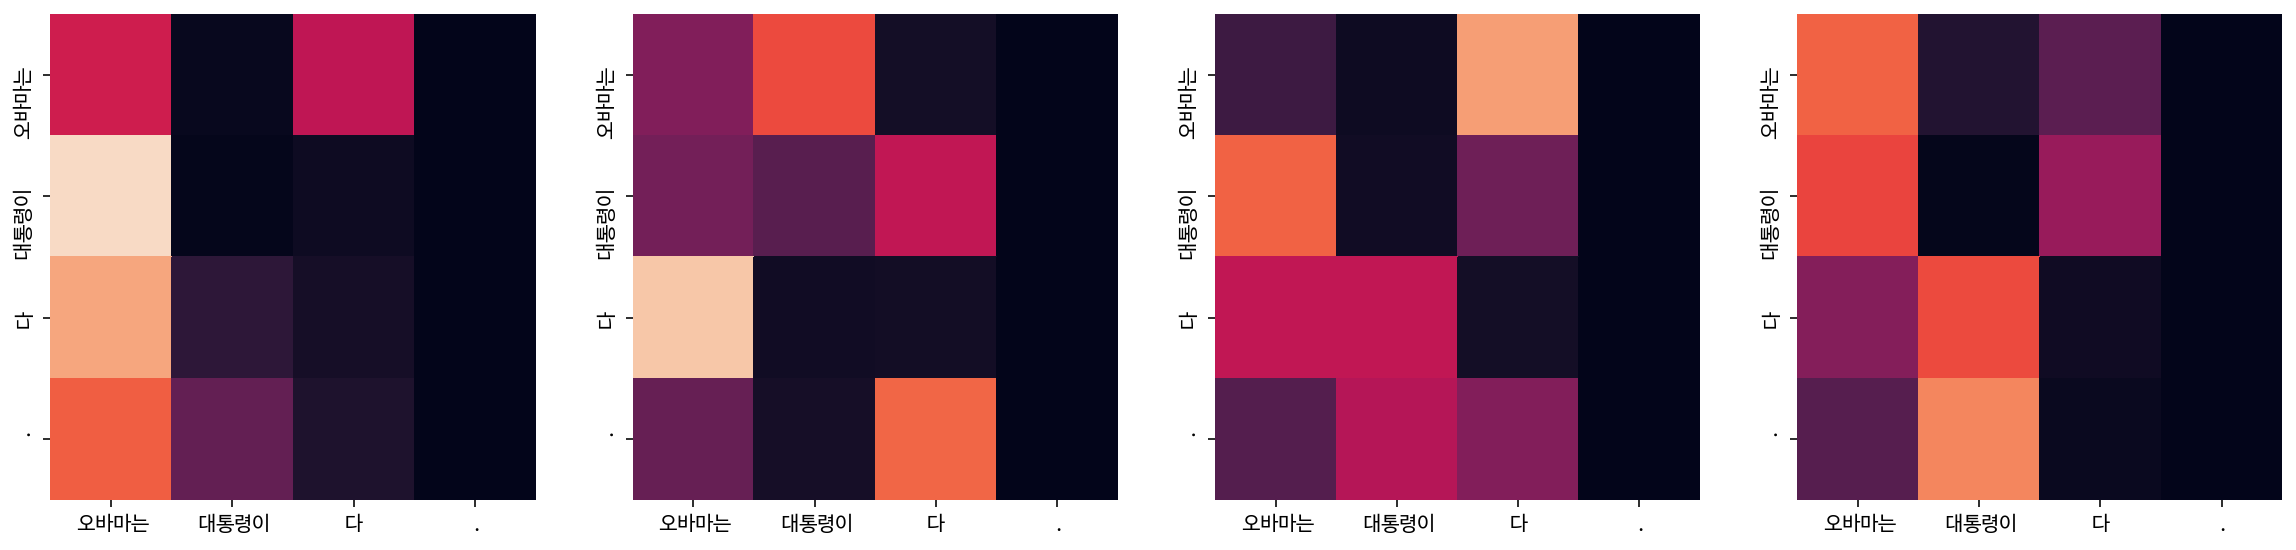

Encoder Layer 2


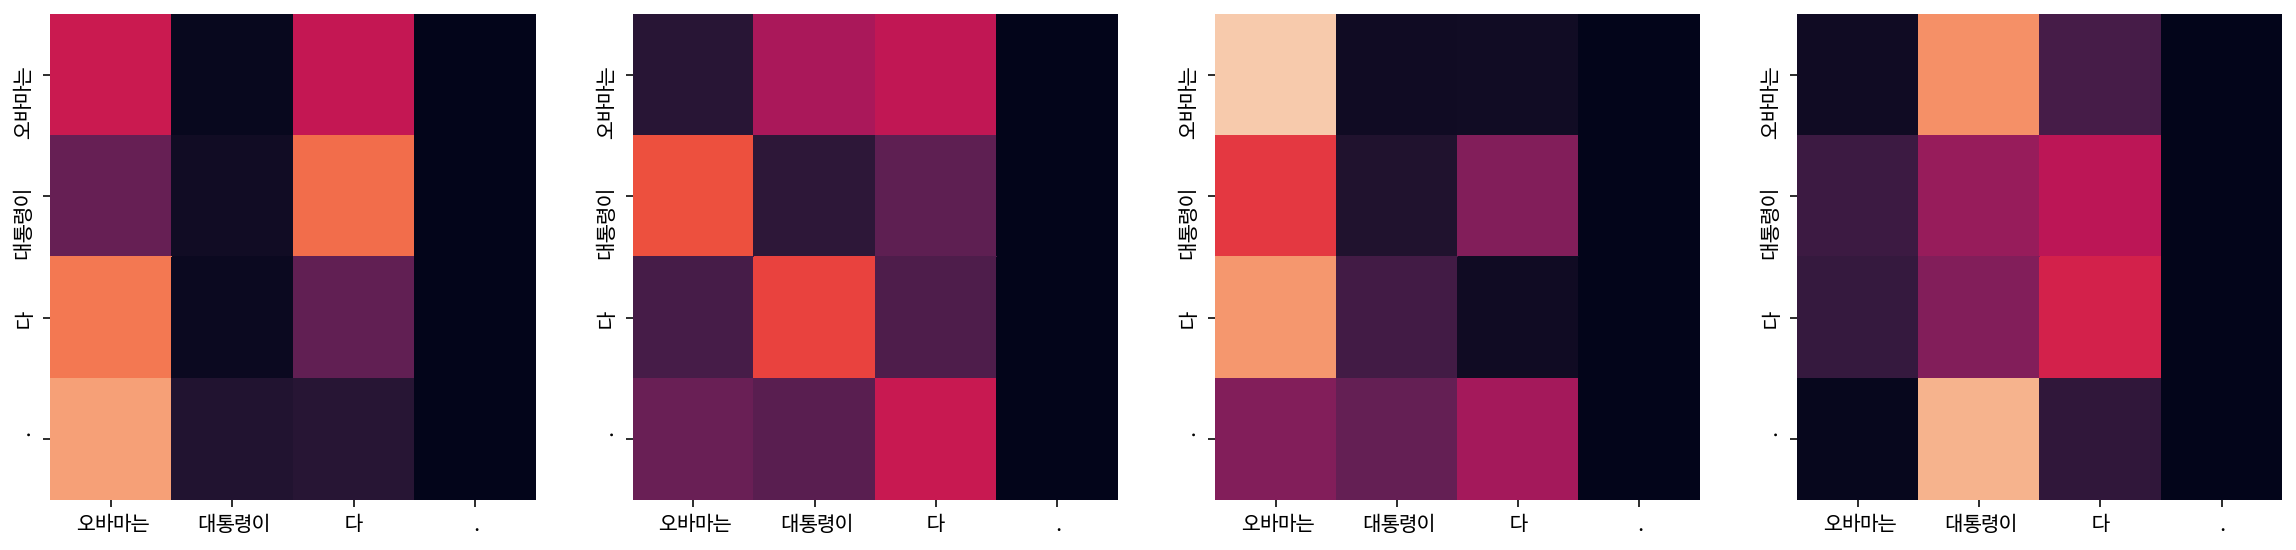

Decoder Self Layer 1


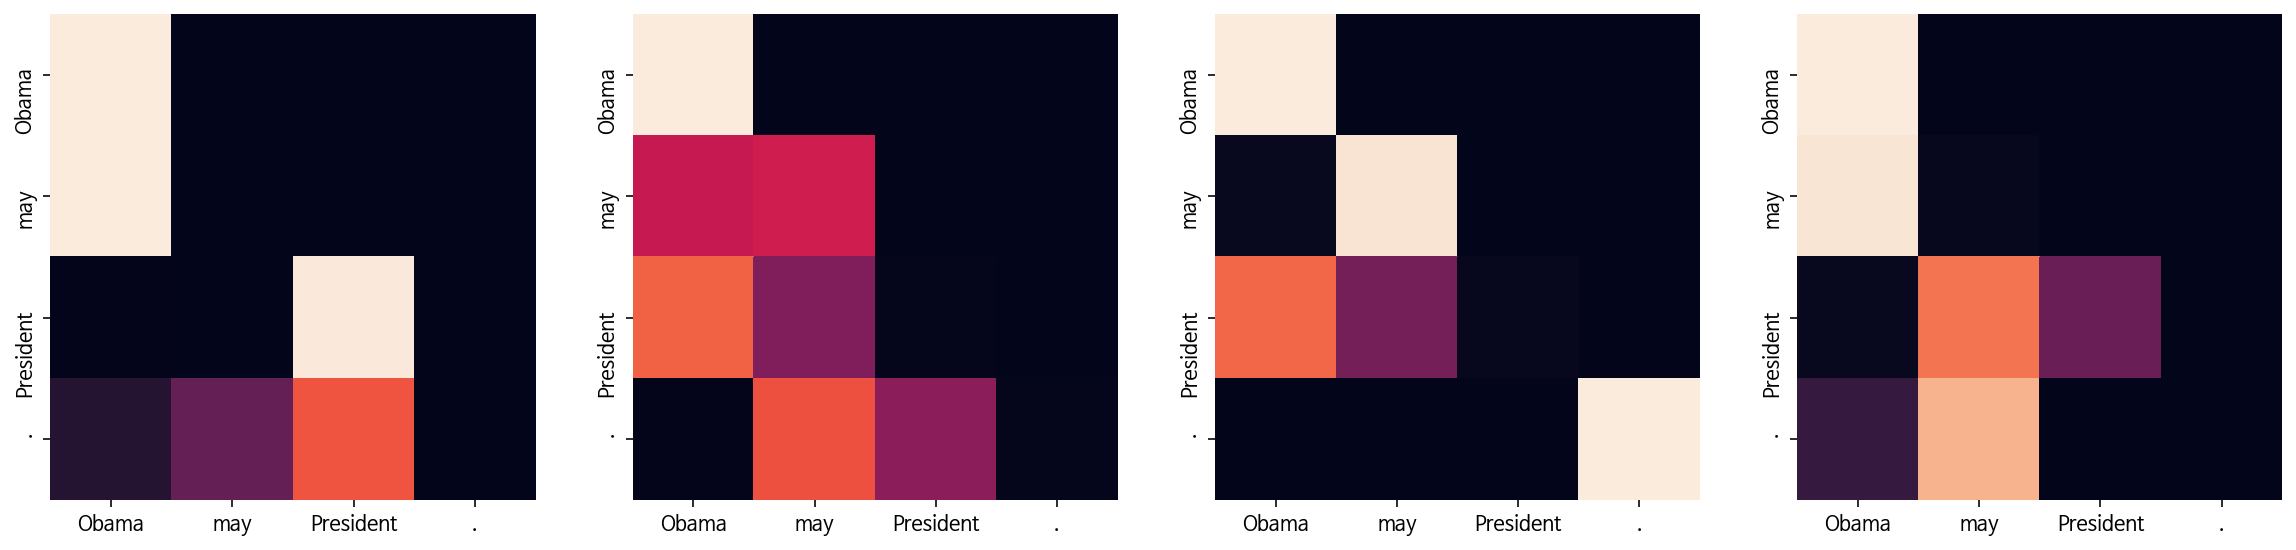

Decoder Src Layer 1


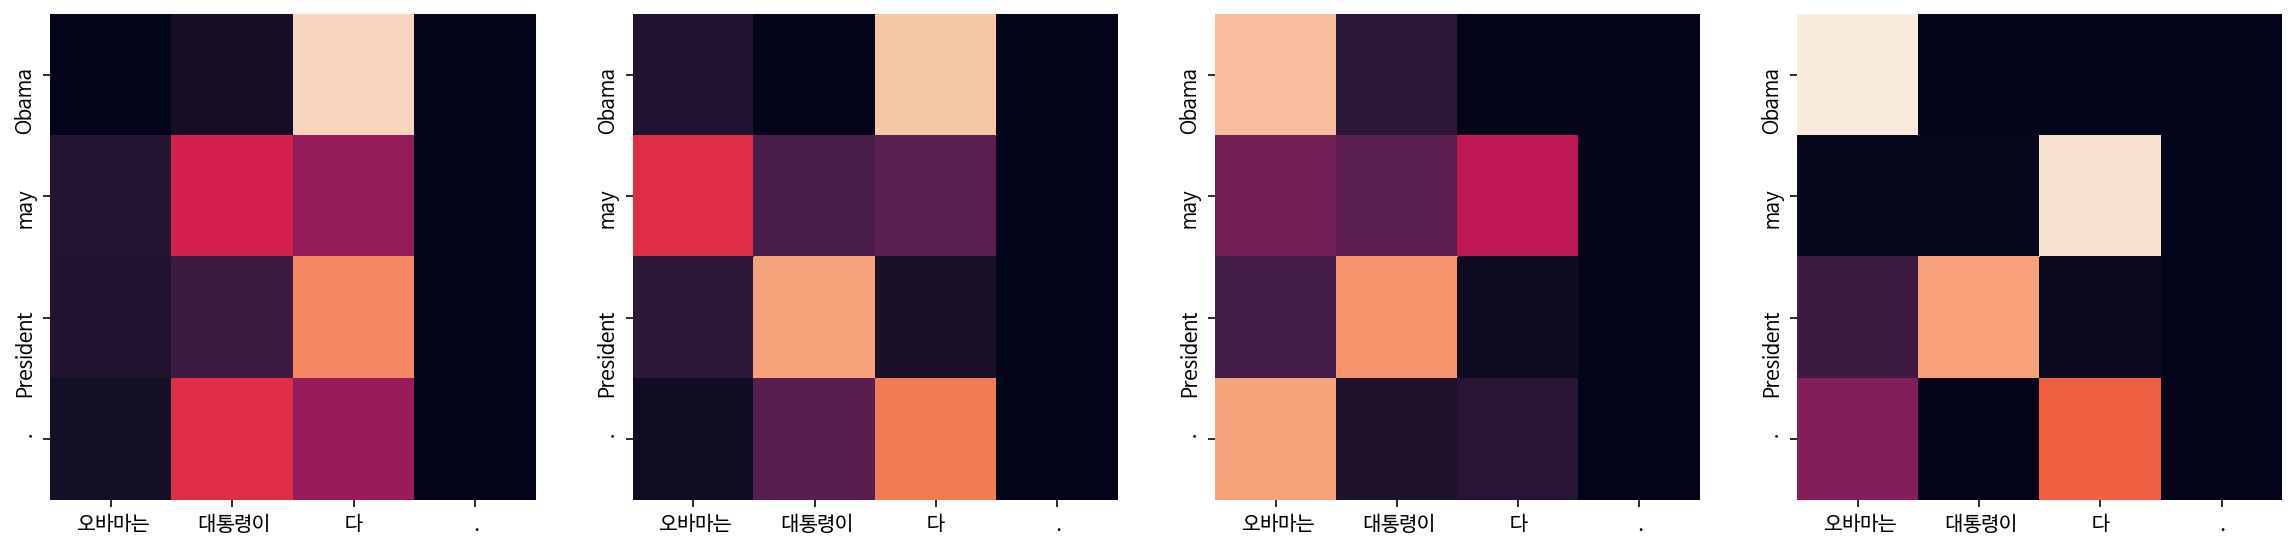

Decoder Self Layer 2


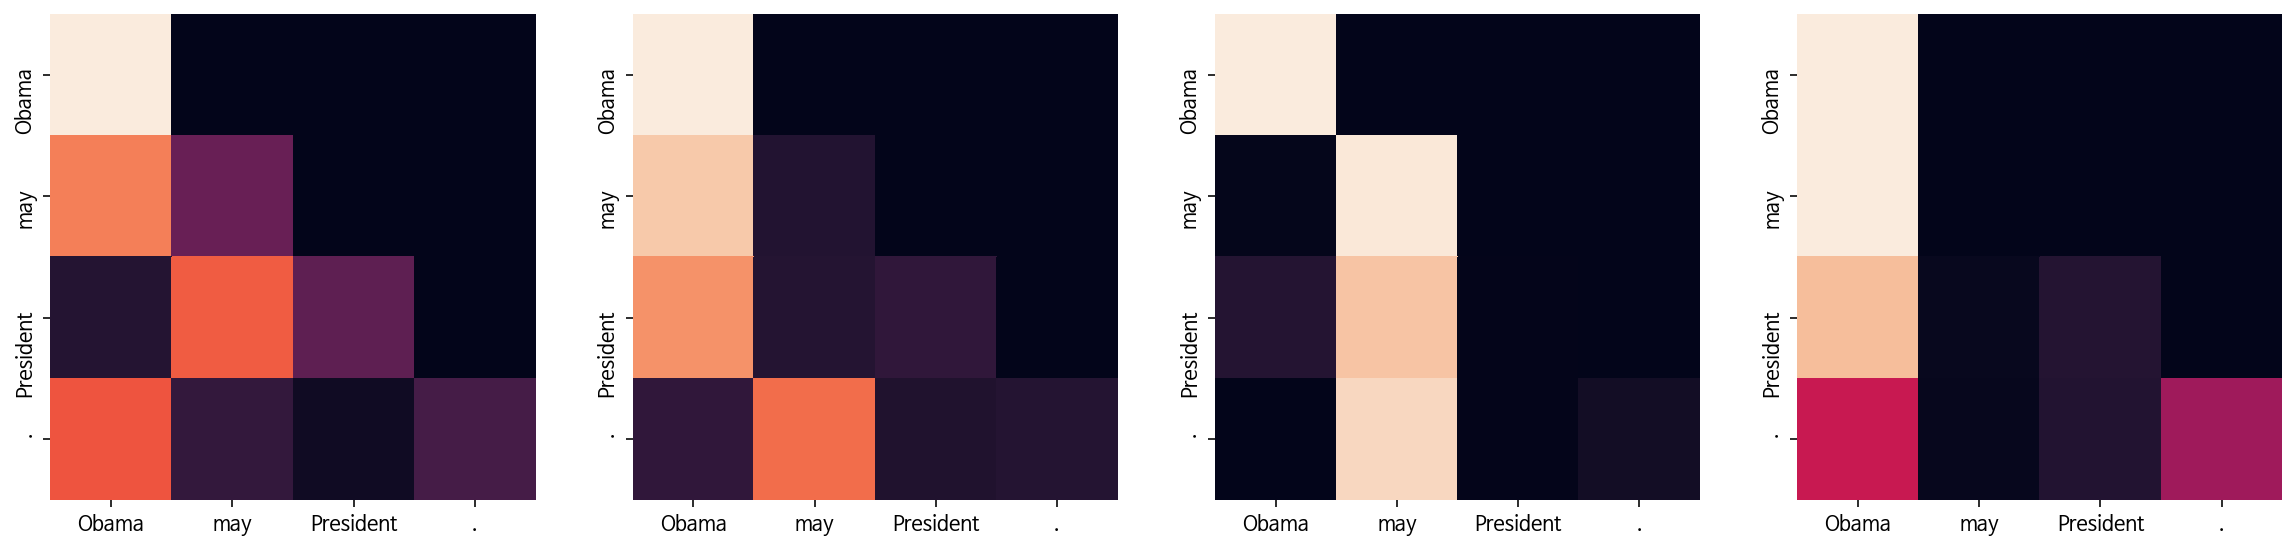

Decoder Src Layer 2


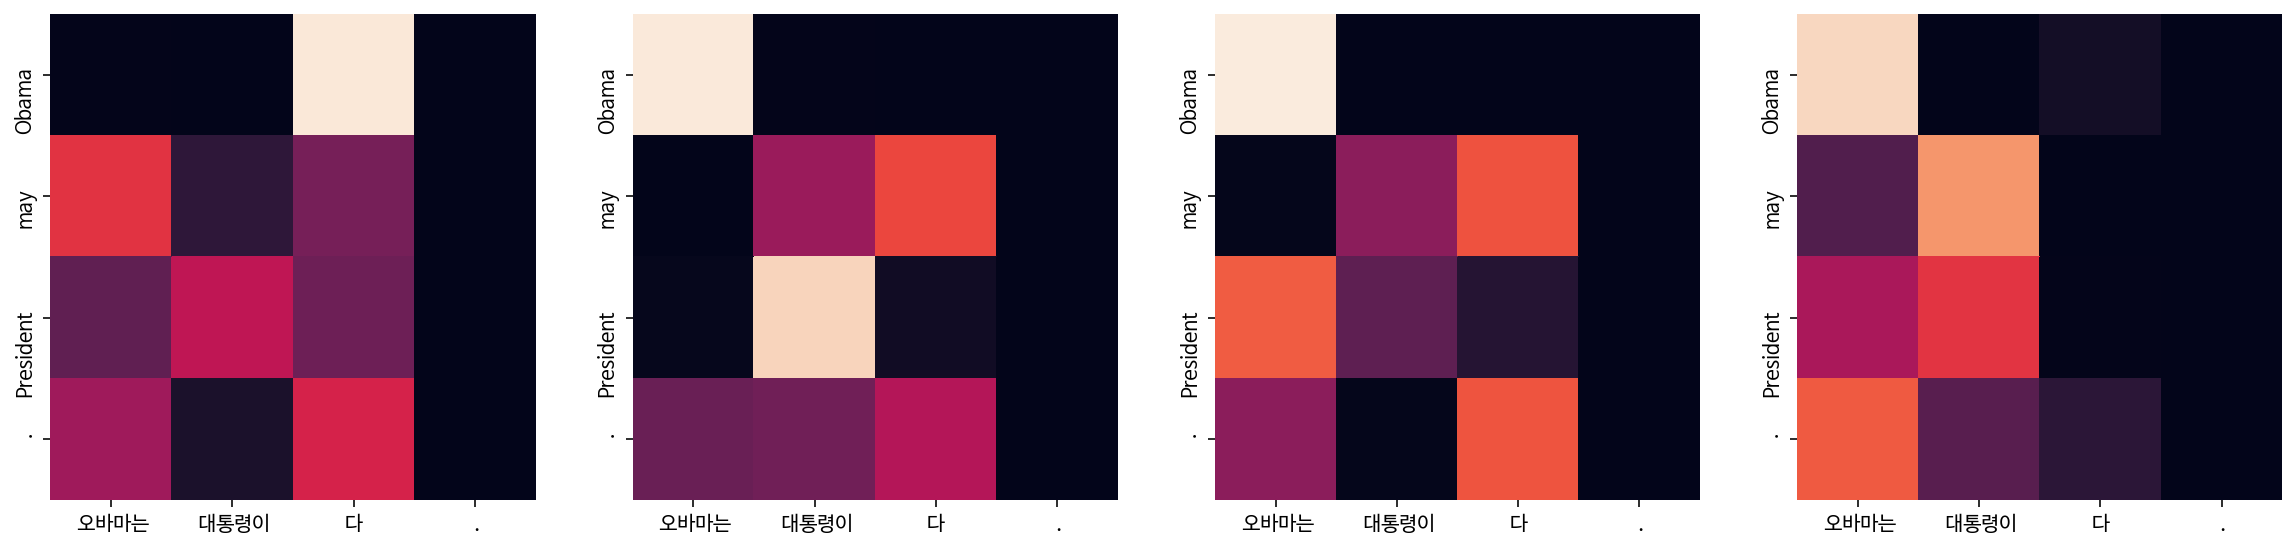

In [48]:
translate('오바마는 대통령이다.',transformer, tokenizer1, tokenizer2, plot_attention = True)

## 7. 평가

정말 다산다난했던 Transformer 프로젝트였다...      
이 프로젝트 하면서 데이터 파이프라인에 대해서 고민을 엄청 많이 하게 되었고 train_step에 대해서도 고민을 많이 하게 되었다.    
제일 힘들었지만 제일 많은 것을 준 프로젝트라 더 신경이 많이 쓰인다.     